In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import math

from pandas import get_dummies
from sklearn import preprocessing
from sklearn import cross_validation, metrics 

%matplotlib inline
plt.style.use('ggplot')

In [9]:
from Bio.SeqUtils import ProtParamData  # Local
from Bio.SeqUtils import IsoelectricPoint  # Local
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import IUPACData
from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

## Feature engineering 
* Log50000
* chemical structure
* kidera factors
* Phylogenetic tree

In [10]:
"""
logarithming according to articles
"""
def log_meas(current):
    new_meas = 1 - math.log(current, 50000.0)
    if new_meas > 1: new_meas = 1
    if new_meas < 0: new_meas = 0
    return new_meas

In [8]:
"""
analyse_seq adds to DataFrame data with peptide sequences  columnns with chemical attributes of peptide
"""

def analyse_seq(sequences):
    physochem = pd.DataFrame()
    mol_weight = []
    aromaticity = []
    instability_index = []
    isoelectric_point = []
    for i in sequences:
        X = ProtParam.ProteinAnalysis(i)
        mol_weight.append(X.molecular_weight())
        aromaticity.append(X.aromaticity())
        instability_index.append(X.instability_index())
        isoelectric_point.append(X.isoelectric_point())
    physochem["molecular_weight"] = mol_weight
    physochem["aromaticity"] = aromaticity
    physochem["instability_index"] = instability_index
    physochem["isoelectric_point"] = isoelectric_point
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(physochem[["molecular_weight","instability_index", "isoelectric_point"]])
    x_scaled = pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
    physochem["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"])
    physochem["instability_index"] = pd.DataFrame(x_scaled["instability_index"])
    physochem["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"])
    return physochem

In [11]:
"""
to_one_hot function replaces "sequence" row in DataFrame data with OneHotEncoded sequences
"""
def to_one_hot(data, length):
    NMers = data[data["peptide_length"] == length].reset_index(drop=True)
    letters = NMers.sequence.apply(list) 
    #data_1Hot = pd.get_dummies(pd.DataFrame(list(letters)))
    #return pd.concat([NMers.drop(["sequence"], axis = 1), data_1Hot], axis = 1)
    return pd.get_dummies(pd.DataFrame(list(letters)))
    

In [10]:
"""
select_by_allele function returns DataFrame, which consists from data for one mhc by its allele
"""
def select_by_allele(data, allele):
    return data[data.mhc == allele].drop(["mhc"], axis = 1).reset_index(drop = True)

In [11]:
"""
add_kidera_ftr function returns DataFrame with kidera factors on column for a given peptide
"""
def add_kidera_ftr(peptides):
    kidera_peptides = pd.DataFrame()
    for i,fact in enumerate(f): 
        kidera_peptides[fact]=[add_kidera(j)[i] for j in peptides]
        #kidera_selected[fact] = pd.DataFrame(data[fact][indexes]).reset_index(drop=True)
    return kidera_peptides

amino=pd.read_csv("acids.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

def add_kidera(pept):
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera

## Dataset

In [12]:
Bdata = pd.read_csv("../mhc/bdata.csv")
Bdata.tail()
Bdata.meas = [log_meas(i) for i in Bdata.meas]

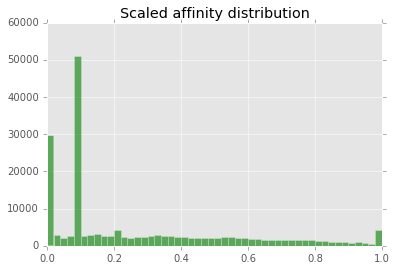

In [11]:
plt.title("Scaled affinity distribution")
hh = plt.hist(Bdata.meas, 50, color = 'green', alpha = 0.6)

## Sequence2Vector

In [10]:
# import modules & set up logging
import logging
import gensim
from gensim.models import word2vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 

In [11]:
def fill_spaces(seq):
    new_seq = list(seq)
    for i in range(1, len(seq)):
        new_seq[i] = " "+ new_seq[i]
    return ''.join(new_seq)

def seq2vec(seq):
    return w2v_model[list(seq)].flatten()

In [12]:
sequences = Bdata.sequence.apply(fill_spaces)

In [13]:
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 4          # Context window size                                                                                    
downsampling = 1e-3 
w2v_dim = 20

print("Training model...")
w2v_model = word2vec.Word2Vec(sequences, workers=num_workers, size = w2v_dim,
                              min_count = min_word_count, window = context, sample = downsampling)
print("Done.")

Training model...
Done.


## Dataframes with 9mers peptides

#### 1. Sequence embedding

In [16]:
seq2vec9mers = pd.DataFrame(Bdata[Bdata.peptide_length == 9].sequence.apply(seq2vec)).reset_index(drop=True)
seq2vec9mers = pd.DataFrame(list(seq2vec9mers.sequence))
seq2vec9mers.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
129808,-0.317054,-0.258697,-0.244551,-0.183234,-0.113984,-0.031625,0.123867,0.061420,-0.341108,-0.421566,...,0.634710,-0.115230,0.131769,-0.266595,-0.192825,0.009962,-0.270660,0.305306,-0.136941,-0.065757
129809,0.055047,-0.443139,-0.074582,-0.507453,-0.089250,0.349006,-0.283546,-0.018094,-0.354461,-0.128479,...,0.635041,-0.159853,0.132459,-0.067021,-0.316902,-0.461175,0.459901,-0.186069,-0.302448,0.074057
129810,-0.294720,-0.060197,0.255941,-0.064387,-0.520793,0.005553,-0.033852,0.220020,-0.454820,-0.425010,...,1.040459,0.159152,0.182609,-0.394871,-0.140906,-0.401900,0.018361,-0.078187,-0.531100,0.195655
129811,-0.390218,-0.350428,-0.346790,-0.280703,-0.302516,0.208832,-0.075165,-0.110501,-0.776802,-0.501667,...,0.515776,0.292212,0.149982,-0.365074,-0.020634,-0.563392,-0.092208,-0.060853,0.417998,-0.066564
129812,0.105427,-0.484514,-0.651534,-0.329830,-0.582140,0.012449,0.101039,0.086377,-0.718743,-0.424763,...,1.040459,0.159152,0.182609,-0.394871,-0.140906,-0.401900,0.018361,-0.078187,-0.531100,0.195655


#### 2.OneHotEncoding

In [13]:
OneHot9mers = to_one_hot(Bdata, 9)
OneHot9mers.tail()

,0_A,0_C,0_D,0_E,0_F,0_G,0_H,0_I,0_K,0_L,...,8_M,8_N,8_P,8_Q,8_R,8_S,8_T,8_V,8_W,8_Y
129808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129809,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
129810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129812,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3. Physochemical properties

In [18]:
PhChemicalData = analyse_seq(Bdata[Bdata.peptide_length == 9].sequence)
PhChemicalData.tail()

,molecular_weight,aromaticity,instability_index,isoelectric_point
129808,0.372089,0.000000,0.280008,0.050803
129809,0.323164,0.111111,0.293921,0.064873
129810,0.528654,0.333333,0.353245,0.085869
129811,0.488379,0.111111,0.220120,0.050803
129812,0.533740,0.555556,0.264814,0.246062


#### 4.Kidera factors

In [19]:
KideraData = add_kidera_ftr(Bdata[Bdata.peptide_length == 9].sequence)
KideraData.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
129808,-0.011111,-0.355556,-0.186667,0.011111,-0.106667,-0.116667,-0.481111,-0.560000,-0.167778,-0.061111
129809,0.172222,-0.478889,-0.176667,-0.304444,0.096667,-0.404444,-0.238889,-0.028889,-0.250000,0.283333
129810,0.367778,0.122222,0.144444,0.002222,-0.051111,-0.146667,-0.062222,0.642222,0.040000,-0.567778
129811,-0.387778,-0.070000,-0.372222,0.003333,0.041111,0.073333,-0.040000,0.148889,-0.108889,0.062222
129812,-0.450000,0.132222,0.138889,-0.887778,-0.113333,-0.695556,0.007778,0.648889,0.823333,-0.368889


## Training XGboost

In [34]:
def xgb_grid_search(data, target):
    
    # split
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    xgdmat_train = xgb.DMatrix(X_train, y_train)
    
    # train
    xgb_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'reg:linear', 'max_depth':300, 'min_child_weight':1}
    """
    print("GridSearch proceeding...")
    cv_xgb = xgb.cv(params = xgb_params, dtrain = xgdmat_train, num_boost_round = 3000,
                    nfold = 5, metrics = ['error'], early_stopping_rounds = 100)
    print("GridSeacrh done.")
    cv_xgb.tail(5)
    """
    print("Training final Xgboost...")
    tuned_xgb = xgb.train(xgb_params, xgdmat_train, num_boost_round = 432)
    print("Done")
    
    xgb.plot_importance(tuned_xgb)
    
    X_test_DMat = xgb.DMatrix(X_test)
    
    predictions = tuned_xgb.predict(X_test_DMat)

        
    print("Accuracy : %.4g" % metrics.r2_score(y_test, predictions))
    """                
    feat_imp = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')"""

Training final Xgboost...
Done
Accuracy : 0.2696


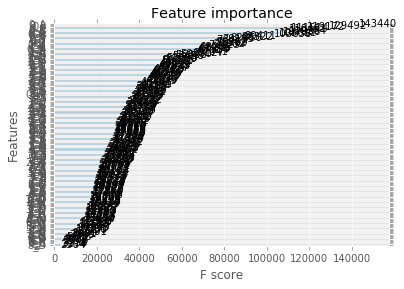

In [35]:
affinity = Bdata[Bdata.peptide_length == 9].meas.reset_index(drop=True)
xgb_grid_search(OneHot9mers, affinity)

In [20]:

"""
params = {"objective": "reg:linear", "booster":"gblinear", "verbose_eval":"50"}
    print("Training Xgboost...")
    gbm = xgb.train(xgb.DMatrix(X_train, y_train), params=params)
"""

'\nparams = {"objective": "reg:linear", "booster":"gblinear", "verbose_eval":"50"}\n    print("Training Xgboost...")\n    gbm = xgb.train(xgb.DMatrix(X_train, y_train), params=params)\n'